<a href="https://colab.research.google.com/github/gdeotale/E4P2/blob/master/Assignment5/Pose%20Estimation/EVA4P2_A5_Human_pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PART 1 - Trying prediction through pytorch HPE model

### Clone below git repo to use the model definiton and configurations.
##### <I> Here we are just loading the model definition, loading pretrained weights and applying relevant configuration.
##### We can also train the model through same git repo.

In [ ]:
! git clone https://github.com/microsoft/human-pose-estimation.pytorch

Cloning into 'human-pose-estimation.pytorch'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 68.78 KiB | 204.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
import torch
import torch.nn as nn
# import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T

# import cv2

import re
import os
import copy
import numpy as np

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import sys
if "/content/human-pose-estimation.pytorch/lib/" not in sys.path:
    sys.path.insert(0, "/content/human-pose-estimation.pytorch/lib/")

import models
from core.config import config
from core.config import update_config

### Here we are downloading the pretrained model weights
#####We are going to use MPII - ResNet50 Model trained on `256x256` sized images
model_file: https://drive.google.com/file/d/1hu4gvQ3iGU-kD3w9Aa7H9GSLOXhi-bYY/view?usp=sharing
#####This model takes a pose image and outputs 16 heatmaps channels for each body joint

In [ ]:
! gdown https://drive.google.com/uc?id=1hu4gvQ3iGU-kD3w9Aa7H9GSLOXhi-bYY

Downloading...
From: https://drive.google.com/uc?id=1hu4gvQ3iGU-kD3w9Aa7H9GSLOXhi-bYY
To: /content/pose_resnet_50_256x256.pth.tar
136MB [00:00, 157MB/s]


### Setting the model config file and model weights location
##### Also updating the model configurations



In [ ]:
CONFIG_FILE = '/content/human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/pose_resnet_50_256x256.pth.tar'

update_config(CONFIG_FILE)

In [ ]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

Tesla P100-PCIE-16GB
True


device(type='cuda')

Load the model

In [ ]:
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model = model.to(device)
model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

Setting model to eval mode

In [ ]:
model.eval()

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

Input the prediction pose image

In [ ]:
# ! wget https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg -O pose.jpg
# ! wget https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png -O pose.png
# ! wget https://github.com/futartup/eva-session-2/blob/master/session5-Human-Pose-Estimation/sample.jpg?raw=true -O sample-pose.jpg
! wget https://static.turbosquid.com/Preview/2015/02/18__11_37_43/1justin_sitting2.jpgf7903c3d-879b-457c-8c7e-4ff03b200801Original.jpg -O pose.jpg
# ! wget https://static.turbosquid.com/Preview/2015/02/18__13_25_29/1.jpgcfab0d85-8957-4942-adde-67723890d821Zoom.jpg -O pose.jpg


--2020-09-04 09:49:44--  https://static.turbosquid.com/Preview/2015/02/18__11_37_43/1justin_sitting2.jpgf7903c3d-879b-457c-8c7e-4ff03b200801Original.jpg
Resolving static.turbosquid.com (static.turbosquid.com)... 13.224.157.97, 13.224.157.38, 13.224.157.118, ...
Connecting to static.turbosquid.com (static.turbosquid.com)|13.224.157.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31883 (31K) [image/jpeg]
Saving to: ‘pose.jpg’

pose.jpg            100%[===================>]  31.14K  --.-KB/s    in 0.008s  

2020-09-04 09:49:44 (3.68 MB/s) - ‘pose.jpg’ saved [31883/31883]



In [ ]:
IMAGE_FILE = 'pose.jpg'

RGB


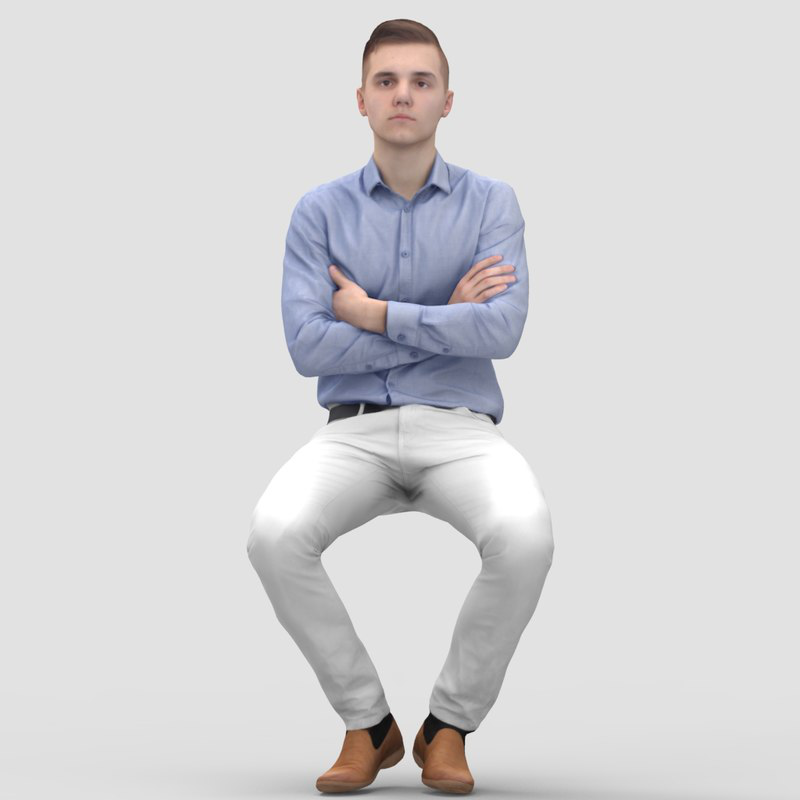

In [ ]:
image = Image.open(IMAGE_FILE)
print(image.mode)
# image = image.convert('RGB')
# image = np.asarray(image)
# Image.fromarray(image)
image

Preparing input to model and getting model prediction

In [ ]:
tr_img

tensor([[[1.7523, 1.7523, 1.7523,  ..., 1.7523, 1.7523, 1.7523],
         [1.7523, 1.7523, 1.7523,  ..., 1.7523, 1.7523, 1.7523],
         [1.7523, 1.7523, 1.7523,  ..., 1.7523, 1.7523, 1.7523],
         ...,
         [1.7352, 1.7352, 1.7352,  ..., 1.6667, 1.6667, 1.6667],
         [1.7352, 1.7352, 1.7352,  ..., 1.6324, 1.6324, 1.6324],
         [1.7180, 1.7180, 1.7180,  ..., 1.6153, 1.6153, 1.6153]],

        [[1.9209, 1.9209, 1.9209,  ..., 1.9209, 1.9209, 1.9209],
         [1.9209, 1.9209, 1.9209,  ..., 1.9209, 1.9209, 1.9209],
         [1.9209, 1.9209, 1.9209,  ..., 1.9209, 1.9209, 1.9209],
         ...,
         [1.9034, 1.9034, 1.9034,  ..., 1.8333, 1.8333, 1.8333],
         [1.9034, 1.9034, 1.9034,  ..., 1.7983, 1.7983, 1.7983],
         [1.8859, 1.8859, 1.8859,  ..., 1.7808, 1.7808, 1.7808]],

        [[2.1346, 2.1346, 2.1346,  ..., 2.1346, 2.1346, 2.1346],
         [2.1346, 2.1346, 2.1346,  ..., 2.1346, 2.1346, 2.1346],
         [2.1346, 2.1346, 2.1346,  ..., 2.1346, 2.1346, 2.

In [ ]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

tr_img = transform(image)
tr_img = tr_img.to(device)
tr_img.is_cuda

True

In [ ]:
output = model(tr_img.unsqueeze(0)).squeeze(0)
output.shape


torch.Size([16, 64, 64])

In [ ]:
_, OUT_HEIGHT, OUT_WIDTH = output.shape

In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

#### JOINTS-ID:  name taken from: http://human-pose.mpi-inf.mpg.de/#download
#### POSE_PAIRS : Used later for plotting lines between body parts

In [ ]:
JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]
JOINTS

['r-ankle',
 'r-knee',
 'r-hip',
 'l-hip',
 'l-knee',
 'l-ankle',
 'pelvis',
 'thorax',
 'upper-neck',
 'head-top',
 'r-wrist',
 'r-elbow',
 'r-shoulder',
 'l-shoulder',
 'l-elbow',
 'l-wrist']

In [ ]:
POSE_PAIRS = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],

# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],

# RIGHT ARM
              [7, 12],
              [12, 11],
              [11, 10],

# LEFT ARM
              [7, 13],
              [13, 14],
              [14, 15]
]

All detections seperately

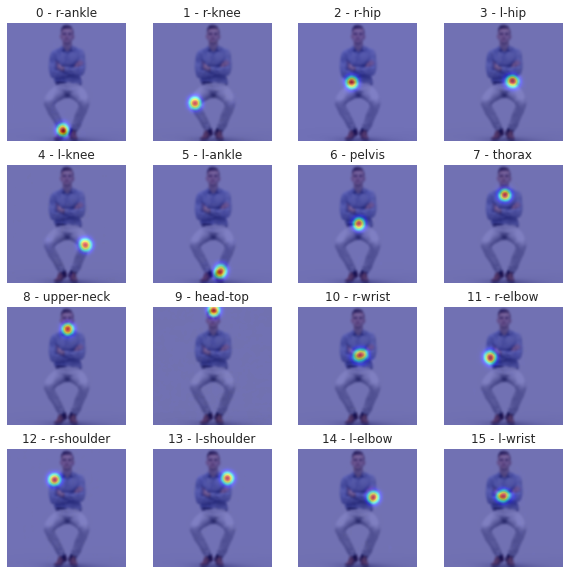

In [ ]:
plt.figure(figsize=(10, 10))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

All detections in single image

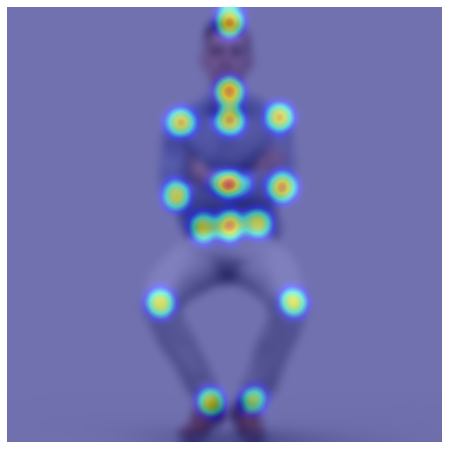

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(image.resize((64, 64)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.4, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

In [ ]:
# plt.figure(figsize=(8, 8))

# combined = np.zeros((64,64))
# for idx, pose_layer in enumerate(output[0]):
#     pose_layer = pose_layer.detach().cpu().numpy()
#     # print(np.min(pose_layer), np.max(pose_layer))
#     # pose_layer = normalize(pose_layer, norm='max')
#     pose_layer = np.clip(pose_layer, 0.1, 1.0)
#     combined = np.add(combined, pose_layer)
#     plt.axis('off')
# plt.imshow(image.resize((64, 64)), cmap='gray', interpolation='bicubic')
# plt.imshow(combined,alpha=0.4, cmap='jet', interpolation='bicubic')


Getting body keypoints on model output channel dimension

In [ ]:
# get_keypoints = lambda pose_heatmaps : [np.unravel_index(np.argmax(a.detach().cpu().numpy(), axis=None), a.detach().cpu().numpy().shape) for a in pose_heatmaps]
get_keypoints = lambda pose_heatmaps : [np.unravel_index(np.argmax(a, axis=None), a.shape) for a in pose_heatmaps]
# get_keypoints = lambda pose_heatmaps : [a.detach().cpu().numpy().shape for a in pose_heatmaps]
get_keypoints(get_detached(output))


[(58, 30),
 (43, 22),
 (32, 28),
 (31, 36),
 (43, 42),
 (57, 36),
 (32, 32),
 (16, 32),
 (12, 32),
 (2, 32),
 (26, 33),
 (27, 24),
 (16, 25),
 (16, 40),
 (26, 40),
 (25, 32)]

Plotting keypoints and joining lines on top of image

In [ ]:
#### Through CV2 ####

# THRESHOLD = 0.0
# OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
# image_p = cv2.imread(IMAGE_FILE)
# pose_layers = get_detached(x=output)
# key_points = list(get_keypoints(pose_layers=pose_layers))
# key_points
# is_joint_plotted = [False for i in range(len(JOINTS))]
# for pose_pair in POSE_PAIRS:
#     from_j, to_j = pose_pair

#     from_thr, (from_x_j, from_y_j) = key_points[from_j]
#     to_thr, (to_x_j, to_y_j) = key_points[to_j]

#     IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

#     from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
#     from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

#     from_x_j, to_x_j = int(from_x_j), int(to_x_j)
#     from_y_j, to_y_j = int(from_y_j), int(to_y_j)

#     if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
#         # this is a joint
#         cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
#         is_joint_plotted[from_j] = True

#     if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
#         # this is a joint
#         cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
#         is_joint_plotted[to_j] = True

#     if from_thr > THRESHOLD and to_thr > THRESHOLD:
#         # this is a joint connection, plot a line
#         cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

In [ ]:
#### Through PIL library ####
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = Image.open(IMAGE_FILE)
draw = ImageDraw.Draw(image_p)
# image_p = np.asarray(image_p)
# pose_layers = get_detached(x=output)
key_points = list(get_keypoints(get_detached(output)))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_body_part, to_body_part = pose_pair

    ## coordinates of body parts in model output channel size ##
    from_y_body_part, from_x_body_part = key_points[from_body_part]
    to_y_body_part, to_x_body_part = key_points[to_body_part]

    ACTUAL_IMG_HEIGHT, ACTUAL_IMG_WIDTH = image_p.size

    ## coordinates of body parts in actual image channel size ##
    from_x_body_part, to_x_body_part = from_x_body_part * ACTUAL_IMG_HEIGHT / OUT_SHAPE[0], to_x_body_part * ACTUAL_IMG_HEIGHT / OUT_SHAPE[0]
    from_y_body_part, to_y_body_part = from_y_body_part * ACTUAL_IMG_WIDTH / OUT_SHAPE[1], to_y_body_part * ACTUAL_IMG_WIDTH / OUT_SHAPE[1]

    from_x_body_part, to_x_body_part = int(from_x_body_part), int(to_x_body_part)
    from_y_body_part, to_y_body_part = int(from_y_body_part), int(to_y_body_part)

    if not is_joint_plotted[from_body_part]:
      # this is a joint
      draw.ellipse((from_x_body_part-8, from_y_body_part-8, from_x_body_part+8, from_y_body_part+8), fill=(255,0,0,0))
      is_joint_plotted[from_body_part] = True

    if not is_joint_plotted[to_body_part]:
      # this is a joint
      draw.ellipse((to_x_body_part-8, to_y_body_part-8, to_x_body_part+8, to_y_body_part+8), fill=(255,0,0,0))
      is_joint_plotted[to_body_part] = True

    # this is a joint connection, plot a line
    draw.line(((from_x_body_part, from_y_body_part), (to_x_body_part, to_y_body_part)), (0, 0, 255), 4)

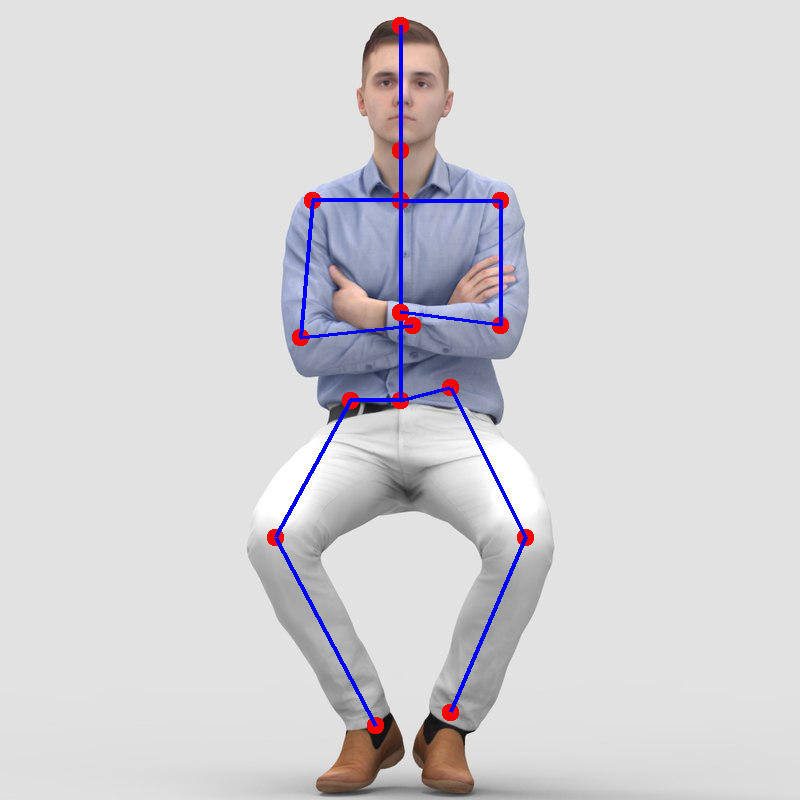

In [ ]:
# Image.fromarray(image_p)
image_p

#PART 2 - Converting pytorch model to onxx and quantize the model

In [ ]:
!pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 2.7MB/s 
     |████████████████████████████████| 4.4MB 40.4MB/s 


Helper functions for model size

In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

In [ ]:
print_size_of_model(model)

Size (MB): 136.331383


In [ ]:
import io
import numpy as np
import torch.onnx

Converting pytorch model to onnx

In [ ]:
# Input to the model
torch_model = copy.deepcopy(model)
torch_model = torch_model.to(device)
print(next(torch_model.parameters()).is_cuda)
batch_size = 1
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True)
x = x.to(device)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "simple_pose_estimation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  # verbose = True,
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

True


In [ ]:
torch_out.shape

torch.Size([1, 16, 64, 64])

Importing onnx model

In [ ]:
import onnx

onnx_model = onnx.load("simple_pose_estimation.onnx")

## verify the model’s structure and confirm that the model has a valid schema ##
onnx.checker.check_model(onnx_model)

In [ ]:
print_size_of_onnx_model(onnx_model)

Size (MB): 136.247923


And also lets quicky test if the model works

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)
np.array(ort_outs).shape

(1, 1, 16, 64, 64)

In [ ]:
ort_outs = ort_outs[0][0]

In [ ]:
ort_outs.shape

(16, 64, 64)

##ONNX Model Quantization

In [ ]:
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode

In [ ]:
quantized_model = quantize(onnx_model, quantization_mode=QuantizationMode.IntegerOps, static=False)

In [ ]:
onnx.save(quantized_model, 'simple_pose_estimation.quantized.onnx')

In [ ]:
print_size_of_onnx_model(quantized_model)

Size (MB): 65.933789


Let's now test if the quantized model works

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.quantized.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)
np.array(ort_outs).shape

(1, 1, 16, 64, 64)

In [ ]:
ort_outs = ort_outs[0][0]

In [ ]:
print(type(ort_outs))
ort_outs.shape


<class 'numpy.ndarray'>


(16, 64, 64)

In [ ]:
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_qp = Image.open(IMAGE_FILE)
draw = ImageDraw.Draw(image_qp)
# image_p = np.asarray(image_p)
# pose_layers = get_detached(x=output)
key_points = list(get_keypoints(ort_outs))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_body_part, to_body_part = pose_pair

    ## coordinates of body parts in model output channel size ##
    from_y_body_part, from_x_body_part = key_points[from_body_part]
    to_y_body_part, to_x_body_part = key_points[to_body_part]

    ACTUAL_IMG_HEIGHT, ACTUAL_IMG_WIDTH = image_qp.size

    ## coordinates of body parts in actual image channel size ##
    from_x_body_part, to_x_body_part = from_x_body_part * ACTUAL_IMG_HEIGHT / OUT_SHAPE[0], to_x_body_part * ACTUAL_IMG_HEIGHT / OUT_SHAPE[0]
    from_y_body_part, to_y_body_part = from_y_body_part * ACTUAL_IMG_WIDTH / OUT_SHAPE[1], to_y_body_part * ACTUAL_IMG_WIDTH / OUT_SHAPE[1]

    from_x_body_part, to_x_body_part = int(from_x_body_part), int(to_x_body_part)
    from_y_body_part, to_y_body_part = int(from_y_body_part), int(to_y_body_part)

    if not is_joint_plotted[from_body_part]:
      # this is a joint
      draw.ellipse((from_x_body_part-8, from_y_body_part-8, from_x_body_part+8, from_y_body_part+8), fill=(255,0,0,0))
      is_joint_plotted[from_body_part] = True

    if not is_joint_plotted[to_body_part]:
      # this is a joint
      draw.ellipse((to_x_body_part-8, to_y_body_part-8, to_x_body_part+8, to_y_body_part+8), fill=(255,0,0,0))
      is_joint_plotted[to_body_part] = True

    # this is a joint connection, plot a line
    draw.line(((from_x_body_part, from_y_body_part), (to_x_body_part, to_y_body_part)), (0, 0, 255), 4)

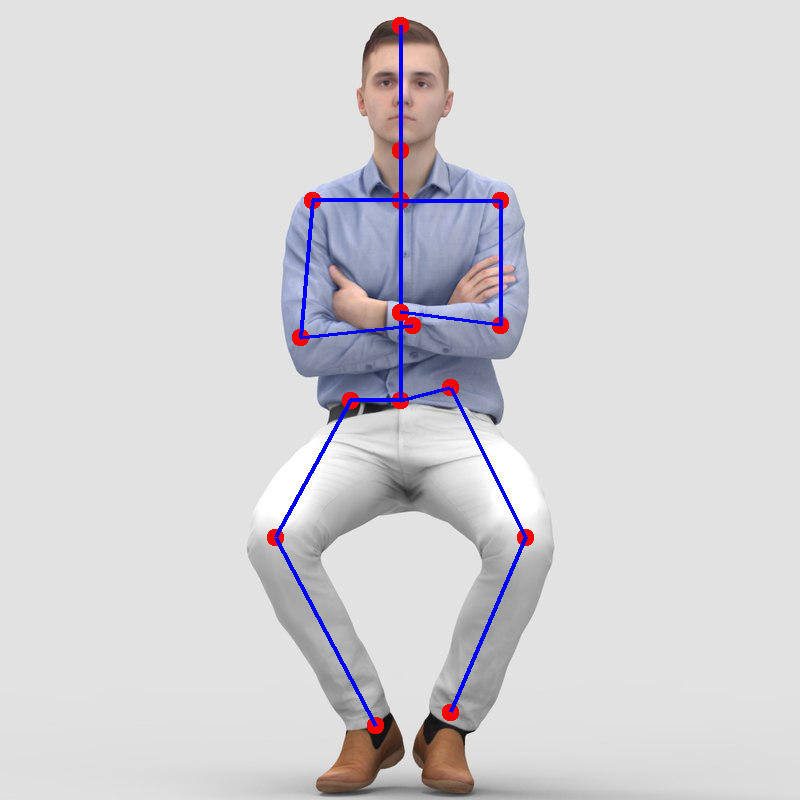

In [ ]:
image_qp